[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldomunaretto/immune_deep_learning/blob/main/notebooks/02_CNN/10_CNN_object_recognition.ipynb)

<h1><font color="#113D68" size=6>Redes Neuronales Convolucionales</font></h1>

<h1><font color="#113D68" size=5>3. Reconocimiento de objetos</font></h1>


---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. Conjunto de datos](#section1)
    * [1.1. 1.1. Cargar el dataset CIFAR-10](#section1.1)
* [2. CNN de línea base](#section2)
    * [2.1. Librería y dataset](#section2.1)
    * [2.2. Normalización](#section2.2)
    * [2.3. One-Hot Encoding](#section2.3)
    * [2.4. Desarrollar CNN de linea base](#section2.4)
    * [2.5. Evaluación del modelo](#section2.5)
* [3. CNN más profunda](#section3)
* [4. Rendimiento del modelo](#section4)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

En esta lección, descubrirá cómo desarrollar y evaluar modelos de Deep Learning para el reconocimiento de objetos en Keras. Después de completar este tutorial paso a paso, sabrá:
* Trabajar con el dataset CIFAR-10.
* Crear una CNN de linea base para el reconocimiento de objetos.
* Mejorar el rendimiento mediante CNN más profundas.

In [ ]:
import tensorflow as tf
# Eliminar warning
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Conjunto de datos</font>

El Instituto Canadiense de Investigación Avanzada (CIFAR, por sus siglas en inglés) desarrolló un conjunto de datos estándar de visión artificial y Deep Learning para este problema.

El conjunto de datos CIFAR-10 consta de 60.000 fotos divididas en 10 clases. Las clases incluyen objetos comunes como aviones, automóviles, pájaros, gatos, etc. El conjunto de datos se divide en 50.000 imágenes para train y 10.000 para test. Las fotos son en color con canales rojo, verde y azul, por lo que tienen un tamaño de $32 × 32 × 3$ píxeles.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información sobre el dataset [CIFAR](http://www.cs.toronto.edu/~kriz/cifar.html)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información sobre la página de Rodrigo Beneson y sus resultados sobre el dataset [CIFAR](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)


<a id="section1.1"></a>
# <font color="#004D7F" size=5>1.1. Cargar el dataset CIFAR-10</font>

El conjunto de datos CIFAR-10 se puede cargar fácilmente en Keras. Keras tiene la posibilidad de descargar automáticamente conjuntos de datos estándar como CIFAR-10 y almacenarlos en el directorio `~/.keras/datasets` usando la función `cifar10.load_data()`.

Este conjunto de datos tiene un tamaño de 163 megabytes, por lo que la descarga puede demorar unos minutos.

El conjunto de datos se almacena como conjuntos Pickle de train/test. Cada imagen se representa como una matriz tridimensional, con dimensiones del canal (rojo, verde, azul), ancho y alto.

In [ ]:
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
import matplotlib.pyplot as plt
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
# show the plot
plt.show()

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. CNN de línea base</font>

El problema de CIFAR-10 se resuelve mejor utilizando una red neuronal convolucional (CNN).

<a id="section2.1"></a>
# <font color="#004D7F" size=5>2.1. Librería y dataset</font>

Podemos comenzar rápidamente importando todas las clases, funciones y el dataset que necesitaremos en este ejemplo.

In [ ]:
# Simple CNN model for the CIFAR-10 Dataset
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import max_norm
from keras.optimizers import SGD
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

<a id="section2.2"></a>
# <font color="#004D7F" size=5>2.2. Normalización</font>

Los valores de píxeles están en el rango de 0 a 255 para cada uno de los canales rojo, verde y azul por o que es una buena práctica normalizarlos.

In [ ]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train, X_test = X_train / 255.0, X_test / 255.0

<a id="section2.3"></a>
# <font color="#004D7F" size=5>2.3. One-Hot Encoding</font>

Las variables de salida se definen como un vector de números enteros de 0 a 1 para cada clase por lo que usamos One-Hot Encoding para transformar las 10 clases del problema.

In [ ]:
# one hot encode outputs
y_train = to_categorical(y_train, num_classes= 10)
y_test = to_categorical(y_test, num_classes = 10)

<a id="section2.4"></a>
# <font color="#004D7F" size=5>2.4. Desarrollar CNN de linea base</font>

Comencemos por definir una estructura CNN de linea base y evaluar qué tan bien se desempeña en el problema. Usaremos una estructura con dos capas convolucionales seguidas de agrupación máxima y un aplanamiento de la red a capas completamente conectadas para hacer predicciones. Nuestra estructura de red de referencia se puede resumir de la siguiente manera:
1. Capa de entrada convolucional, 32 mapas de características con un tamaño de $3 × 3$, una función de activación ReLu y una restricción de peso de la norma máxima establecida en 3.
2. Dropout en 20%.
3. Capa convolucional, 32 mapas de características con un tamaño de $3 × 3$, una función de activación ReLu y una restricción de peso de la norma máxima establecida en 3.
4. Capa Max Pool con el tamaño $2 × 2$.
5. Aplanar la capa.
6. Capa totalmente conectada con 512 unidades y función de activación de rectificador.
7. Dropout en 50%.
8. Capa de salida totalmente conectada con 10 unidades y función de activación Softmax.

Finalmente, se utiliza una función de pérdida logarítmica con el algoritmo de optimización SGD configurado con un gran momentum y peso `decay`, comenzando con una tasa de aprendizaje de 0,01.

A continuación se proporciona una visualización de la estructura de la red.


In [ ]:
from IPython.display import Image, display

# Suponiendo que el nombre de la imagen es 'mi_imagen.jpg'
display(Image('Img/4_Objetos_lineaBase.png'))

In [ ]:
# Definir la arquitectura del modelo
model = Sequential()

# Capa de entrada convolucional, 32 mapas de características con un tamaño de 3x3, una función de activación ReLU y una restricción de peso de la norma máxima establecida en 3.
model.add(Conv2D(32, (3, 3), activation='relu', kernel_constraint=max_norm(3), input_shape=(32, 32, 3)))

# Dropout en 20%
model.add(Dropout(0.2))

# Capa convolucional, 32 mapas de características con un tamaño de 3x3, una función de activación ReLU y una restricción de peso de la norma máxima establecida en 3.
model.add(Conv2D(32, (3, 3), activation='relu', kernel_constraint=max_norm(3)))

# Capa Max Pool con el tamaño 2x2
model.add(MaxPooling2D())

# Aplanar la capa
model.add(Flatten())

# Capa totalmente conectada con 512 unidades y función de activación de rectificador
model.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))

# Dropout en 50%
model.add(Dropout(0.5))

# Capa de salida totalmente conectada con 10 unidades y función de activación Softmax
model.add(Dense(10, activation='softmax'))

model.summary()

In [ ]:
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs

sgd = SGD(learning_rate=lrate, momentum=0.9, weight_decay= decay, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

<a id="section2.5"></a>
# <font color="#004D7F" size=5>2.5. Evaluación del modelo</font>

Ajustamos este modelo con 25 épocas y un tamaño de batch de 32.

Se pone 25 con fines de obtener un resultado rápido pero pruebe con 150 épocas que sería más apropiado

In [ ]:
# Fit the model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))
# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. CNN más profunda</font>

En esta sección, analizaremos la ampliación del tamaño y la complejidad de nuestro modelo. Podemos introducir una ronda adicional de convoluciones con muchos más mapas de características. Usaremos el mismo patrón de capas convolucional, Dropout, convolucional y de Max-Pooling.

Podemos resumir una nueva arquitectura de red como:
1. Capa de entrada convolucional, 32 mapas de $3 × 3$ y función de activación ReLU.
2. Capa Dropout al 20%.
3. Capa convolucional, 32 mapas de $3 × 3$ y una función de activación ReLU.
4. Capa Max-Pooling de $2 × 2$.
5. Capa convolucional, 64 mapas de $3 × 3$ y función de activación ReLU.
6. Capa Dropout al 20%.
7. Capa convolucional, 64 mapas de $3 × 3$ y función de activación ReLU.
8. Capa Max-Pooling de $2 × 2$.
9. Capa convolucional, 128 mapas de $3 × 3$ y función de activación ReLU.
10. Capa Dropout al 20%.
11. Capa convolucional, 128 de $3 × 3$ y función de activación ReLU.
12. Capa Max-Pooling de $2 × 2$.
13. Aplanar la capa.
14. Capa Dropout al 20%.
15. Capa totalmente conectada con 1.024 neuronas y función de activación ReLU.
16. Capa Dropout al 20%.
17. Capa totalmente conectada con 512 neuronas y función de activación ReLU.
18. Capa Dropout al 20%.
19. Capa de salida totalmente conectada con 10 unidades y función de activación Softmax.

In [ ]:
# Create the model
???

# Compile model
???

# Fit the model
???

# Final evaluation of the model
???

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6>4. Rendimiento del modelo </font>

Trabajo para vosotros:
* **Entrena para más épocas**. Es común entrenar grandes redes neuronales convolucionales durante cientos o miles de épocas.
* **Data Augmentation**. Los objetos de la imagen varían en su posición.
* **Topología de red más profunda**. La red más grande presentada es profunda, pero se podrían diseñar redes más grandes para el problema.

Epoch 1/25
782/782 [==============================] - 149s 188ms/step - loss: 1.6215 - accuracy: 0.4006 - val_loss: 1.2681 - val_accuracy: 0.5502
Epoch 2/25
782/782 [==============================] - 148s 190ms/step - loss: 1.2560 - accuracy: 0.5466 - val_loss: 1.0952 - val_accuracy: 0.6123
Epoch 3/25
782/782 [==============================] - 151s 193ms/step - loss: 1.1147 - accuracy: 0.6042 - val_loss: 0.9687 - val_accuracy: 0.6612
Epoch 4/25
782/782 [==============================] - 148s 189ms/step - loss: 1.0271 - accuracy: 0.6360 - val_loss: 0.8552 - val_accuracy: 0.7003
Epoch 5/25
782/782 [==============================] - 148s 189ms/step - loss: 0.9632 - accuracy: 0.6597 - val_loss: 0.8004 - val_accuracy: 0.7207
Epoch 6/25
782/782 [==============================] - 147s 188ms/step - loss: 0.9207 - accuracy: 0.6762 - val_loss: 0.7848 - val_accuracy: 0.7305
Epoch 7/25
782/782 [==============================] - 141s 181ms/step - loss: 0.8794 - accuracy: 0.6929 - val_loss: 0.7839 -

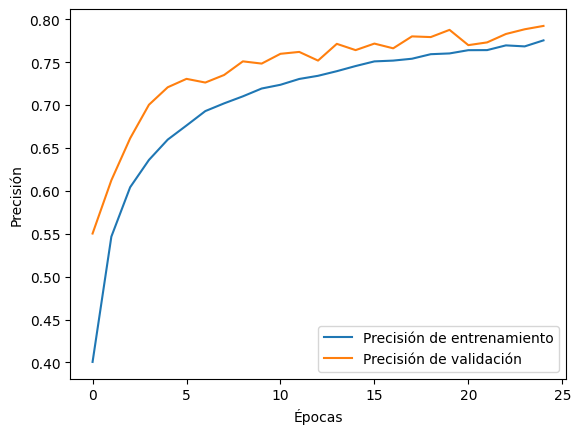

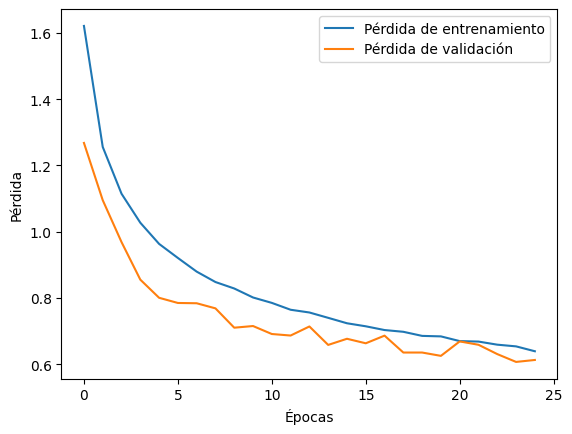

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Cargar y preprocesar el conjunto de datos CIFAR-10
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Normalizar los datos de entrada a valores entre 0 y 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Definir la arquitectura del modelo
model = models.Sequential()

# Primera capa convolucional con 32 filtros, tamaño de kernel 3x3, padding 'same' y activación ReLU
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Segunda capa convolucional con 64 filtros, tamaño de kernel 3x3, padding 'same' y activación ReLU
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Tercera capa convolucional con 128 filtros, tamaño de kernel 3x3, padding 'same' y activación ReLU
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# Aplanar la capa
model.add(layers.Flatten())

# Capa totalmente conectada con 512 unidades y activación ReLU
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

# Capa de salida totalmente conectada con 10 unidades y activación Softmax
model.add(layers.Dense(10, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Precisión en el conjunto de prueba: {test_acc}')

# Graficar la precisión y la pérdida durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>